# COMP551: Project 4

In [0]:
import pandas as pd
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
transform = transforms.Compose([transforms.Resize(28,28),
                               transforms.ToTensor(),
                               transforms.Lambda(lambda x: x.repeat(3,1,1)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True,num_workers=2)
validloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False,num_workers=2)



In [4]:
#*********************************************************************
# model part
import torchvision.models as models
# use pretrained model:
model = models.squeezenet1_1(pretrained = True)
#import OrderedDicted to corectly align the network layers


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.torch/models/squeezenet1_1-f364aa15.pth
4966400it [00:00, 22352218.67it/s]


In [5]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [0]:
#import nn to modify features
from collections import OrderedDict
from torch import nn
#create classifier which fit our num of outputs
classifier2= nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
#replace the model's classifier with this new classifier 


classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 10, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(1)
)
model.classifier = classifier
model.forward = lambda x: model.classifier(model.features(x)).view(x.size(0), 10)


In [7]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [0]:
#import optimizer:
from torch import optim
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0003, momentum=0.9)

In [0]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        #check if the training is correct: print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/100
        
    return epoch_loss, epoch_acc

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
    
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/100
    
    return epoch_loss, epoch_acc

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [12]:
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
valid_losses=[]
valid_acc =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
# define number of epochs
epochs = 16 
epoch = 0

for e in range(epochs):
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
Epoch: 1 Train Loss : 116.7783  Train Accuracy: 0.5781
Epoch: 1 Validation Loss : 34.3336  Validation Accuracy 0.8936
2
Epoch: 2 Train Loss : 37.9326  Train Accuracy: 0.8817
Epoch: 2 Validation Loss : 13.7430  Validation Accuracy 0.9582
3
Epoch: 3 Train Loss : 20.1371  Train Accuracy: 0.9448
Epoch: 3 Validation Loss : 9.8057  Validation Accuracy 0.9689
4
Epoch: 4 Train Loss : 14.3951  Train Accuracy: 0.9618
Epoch: 4 Validation Loss : 9.0816  Validation Accuracy 0.9717
5
Epoch: 5 Train Loss : 11.8238  Train Accuracy: 0.9687
Epoch: 5 Validation Loss : 7.0228  Validation Accuracy 0.9782
6
Epoch: 6 Train Loss : 10.0558  Train Accuracy: 0.9730
Epoch: 6 Validation Loss : 7.0101  Validation Accuracy 0.9787
7
Epoch: 7 Train Loss : 9.1411  Train Accuracy: 0.9764
Epoch: 7 Validation Loss : 6.8501  Validation Accuracy 0.9802
8
Epoch: 8 Train Loss : 8.1182  Train Accuracy: 0.9789
Epoch: 8 Validation Loss : 6.4499  Validation Accuracy 0.9810
9
Epoch: 9 Train Loss : 7.1496  Train Accuracy: 0.9811


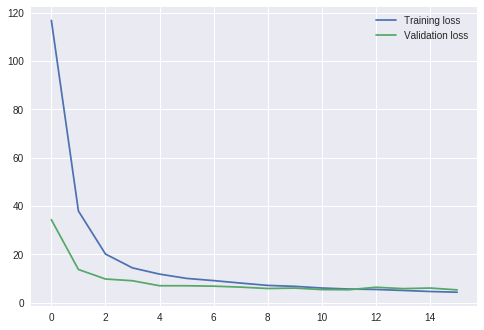

In [15]:
#Plot training and validation losses
import matplotlib.pyplot as plt
import numpy as np
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

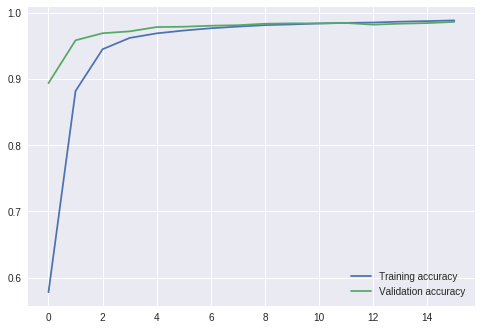

In [16]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [17]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset        loss
  0       1   train  116.778300
  1       2   train   37.932581
  2       3   train   20.137060
  3       4   train   14.395104
  4       5   train   11.823784
  5       6   train   10.055781
  6       7   train    9.141091
  7       8   train    8.118172
  8       9   train    7.149611
  9      10   train    6.767524
  10     11   train    6.076467
  11     12   train    5.657974
  12     13   train    5.481333
  13     14   train    5.069684
  14     15   train    4.637840
  15     16   train    4.343223
  16      1   valid   34.333620
  17      2   valid   13.743031
  18      3   valid    9.805670
  19      4   valid    9.081606
  20      5   valid    7.022783
  21      6   valid    7.010062
  22      7   valid    6.850102
  23      8   valid    6.449889
  24      9   valid    5.873143
  25     10   valid    6.054310
  26     11   valid    5.430778
  27     12   valid    5.366306
  28     13   valid    6.398665
  29     14   valid    5.821326
  30     15   valid    6.066233
  31     16   valid    5.307630,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector001: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})